# MLP

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sanfis import SANFIS
from sanfis import plottingtools
import torch
from pandas import DataFrame
from pandas import concat
from tensorflow import keras, Tensor
import torch.nn as nn 
import torch.nn.functional as F
import optuna
# matplotlib.style.use("classic")
#Função auxiliar
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [2]:
dados = np.loadtxt("Dados/dados_com_ruido.csv", delimiter=',')
t = np.loadtxt("instante.csv", delimiter=',')
dados.shape

(6000, 4)

In [3]:
n_in = 1 #atrasos de tempo para prever o próximo estado

D = series_to_supervised(dados, n_in=n_in, n_out=1)
f_treino = 0.7 

D_treino = D.iloc[0:int(f_treino*len(D)), :]
D_teste = D.iloc[int(f_treino*len(D)):,:]

sc = MinMaxScaler()
sc2 = MinMaxScaler()
sc2.fit(D_treino.iloc[:,-1].values.reshape(-1,1))
sc.fit(D_treino)

D_treino_normalizado = sc.transform(D_treino)
D_teste_normalizado = sc.transform(D_teste)

x_treino = D_treino_normalizado[:, 0:-4]
y_treino = D_treino_normalizado[:,-4:]

x_teste = D_teste_normalizado[:, 0:-4]
y_teste = D_teste_normalizado[:,-4:]

# fig, ((ax1,ax2), (ax2,ax3)) = plt.subplots(2,2,figsize=(20,10))
# ax1.plot(y_treino[:,1])

x_treino, x_teste, y_treino, y_teste = np.array(x_treino), np.array(x_teste), np.array(y_treino)[:,-1].reshape(-1,1), np.array(y_teste)[:,-1].reshape(-1,1)

In [4]:
def SLFN():
    modelo = keras.Sequential([
        keras.layers.Dense(20, activation='relu', input_shape=[4]),
        keras.layers.Dense(1)
    ])
    optimizer = keras.optimizers.Adam()
    modelo.compile(loss="mse", optimizer=optimizer)
    return modelo 
modelo = SLFN()

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)


history = modelo.fit(x_treino, y_treino, validation_data=[x_teste, y_teste], verbose=1, epochs=100, batch_size=10, callbacks=earlyStopping)

Epoch 1/100
420/420 [==============================] - 4s 4ms/step - loss: 0.0580 - val_loss: 0.0075
Epoch 2/100
420/420 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0093
Epoch 3/100
420/420 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0057
Epoch 4/100
420/420 [==============================] - 1s 3ms/step - loss: 9.6607e-04 - val_loss: 0.0036
Epoch 5/100
420/420 [==============================] - 1s 3ms/step - loss: 1.3593e-04 - val_loss: 0.0014
Epoch 6/100
420/420 [==============================] - 1s 3ms/step - loss: 8.0070e-05 - val_loss: 8.6233e-04
Epoch 7/100
420/420 [==============================] - 1s 3ms/step - loss: 6.7275e-05 - val_loss: 7.4540e-04
Epoch 8/100
420/420 [==============================] - 1s 3ms/step - loss: 5.9129e-05 - val_loss: 6.0001e-04
Epoch 9/100
420/420 [==============================] - 1s 3ms/step - loss: 5.4267e-05 - val_loss: 4.6603e-04
Epoch 10/100
420/420 [=============================

In [5]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


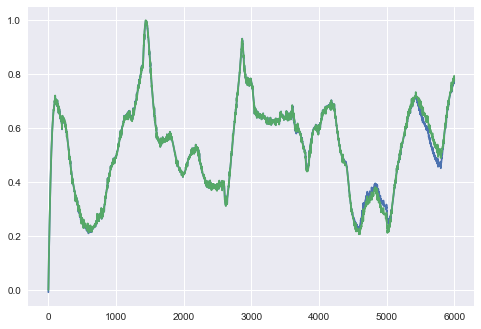

In [6]:
X = np.concatenate([x_treino, x_teste])
Y = np.concatenate([y_treino, y_teste])
plt.plot(modelo.predict(X))
plt.plot(Y)

In [7]:
modelo.save("modelos/MLP")

INFO:tensorflow:Assets written to: modelos/MLP\assets
